In [8]:
import torch
print(torch.__version__)

1.4.0


In [9]:
from scripts.datasets import CaptionsDataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt 
import torchvision
from torchvision import transforms, utils
import numpy as np 
import json 
%matplotlib inline

In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
def convert_idx_to_word(idx, dic):
    for key, val in dic.items(): 
        if idx == val:
            return key 

### Load the Caption Dataset 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The 0 th image...
<start> two young guys with shaggy hair look at their hands while hanging out in the yard <end> 
The 1 th image...
<start> several men in hard hats are operating a giant pulley system <end> <pad> <pad> <pad> <pad> <pad> 
The 2 th image...
<start> a little girl in a pink dress going into a wooden cabin <end> <pad> <pad> <pad> <pad> 
The 3 th image...
<start> a man in a blue shirt is standing on a ladder cleaning a window <end> <pad> <pad> 
The 4 th image...
<start> two guy cooking and joking around with the camera <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> 
The 5 th image...
<start> two people in the photo are playing the guitar and the other is poking at him <end> 
The 6 th image...
<start> a man sits in a chair while holding a large stuffed animal of a lion <end> <pad> 
The 7 th image...
<start> a girl is on rollerskates talking on her cellphone standing in a parking lot <end> <pad> <pad> 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The 8 th image...
<start> three people are standing outside near large pipes and a metal railing <end> <pad> <pad> <pad> <pad> 
The 9 th image...
<start> two men in germany jumping over a rail at the same time without shirts <end> <pad> <pad> 


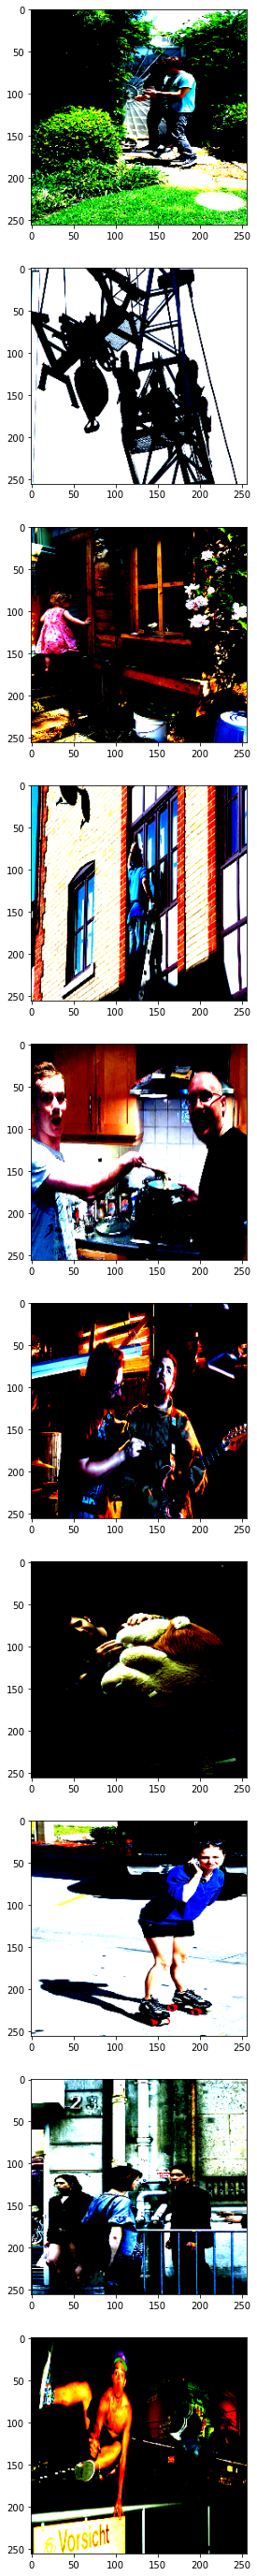

In [12]:
SPLIT = 'TRAIN'
DATA_PATH = '/home/ec2-user/SageMaker/efs/200005/processed_flickr30k'
word_dict = '/home/ec2-user/SageMaker/efs/200005/processed_flickr30k/WORDMAP_flickr30k_5_cap_per_img_5_min_word_freq.json'
with open(word_dict, 'r') as f:
    dic = json.load(f)

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

caption_dataset = CaptionsDataset(data_path=DATA_PATH, split=SPLIT, transform=transforms.Compose([transforms.ToTensor(), normalize]))
display_num = 10 
fig = plt.figure(figsize=(50, 50))

for i in range(display_num):
    image, caption, caplen = caption_dataset[i*5]
    for idx in caption:
        print(f"{convert_idx_to_word(idx, dic)}", end=" ")
    print() 
    resized_image = np.transpose(image, (1, 2, 0))
    fig.add_subplot(display_num, 1, i+1)
    plt.imshow(resized_image)
plt.show() 

### DataLoader 

In [20]:
def collate_fn(data):
    """Create mini-batch tensors from the list of tuples (image, caption)

    We should build custom collate_fun rather than using default collate_fn, 
    because merging caption (including padding) is not supported in default.

    Args:
       data: list of tuple (image, caption, caplen).
            - image: torch tensor of shape (3, 256, 256).
            - caption: torch tensor of shape (?); variable length.
            - caplen: length of the caption 

    Returns:
            images: torch tensor of shape (batch_size, 3, 256, 256)
            targets: torch tensor of shape (batch_size, padded_length).
            lengths: list; valid length for each padded caption. 
    """
    # Sort a data list by caption length (descending order).
    data.sort(key=lambda x: len(x[1]), reverse=True)
    images, captions, lengths = zip(*data)

    # Merge images (from tuple of 3D tensor to 4D tensor).
    images = torch.stack(images, 0)

    # Merge captions (from tuple of 1D tensor to 2D tensor).
    lengths = list(lengths)
    targets = torch.zeros(len(captions), max(lengths)).long() 
    for i, cap in enumerate(captions):
        cap = torch.Tensor(cap)
        end = lengths[i]
        targets[i, :end] = cap[:end]
    return images, targets, lengths 

The 52 th image...
The 49 th image...
The 30 th image...
The 64 th image...
torch.Size([4, 3, 256, 256]) torch.Size([4, 18])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[['<start>', 'men', 'walking', 'down', 'a', 'street', 'with', 'children', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'], ['<start>', 'a', 'boy', 'jump', 'kicking', 'over', 'three', 'kids', 'kicking', 'wood', 'during', 'a', '<unk>', '<unk>', 'do', 'competition', '<end>', '<pad>'], ['<start>', 'a', 'man', 'is', 'posing', 'next', 'to', 'a', '<unk>', 'with', 'a', 'cup', 'of', 'coffee', '<end>', '<pad>', '<pad>', '<pad>'], ['<start>', 'a', 'woman', 'in', 'a', 'headscarf', 'uses', 'a', 'telescope', 'to', 'look', 'out', 'over', 'the', 'city', 'and', 'bay', '<end>']]


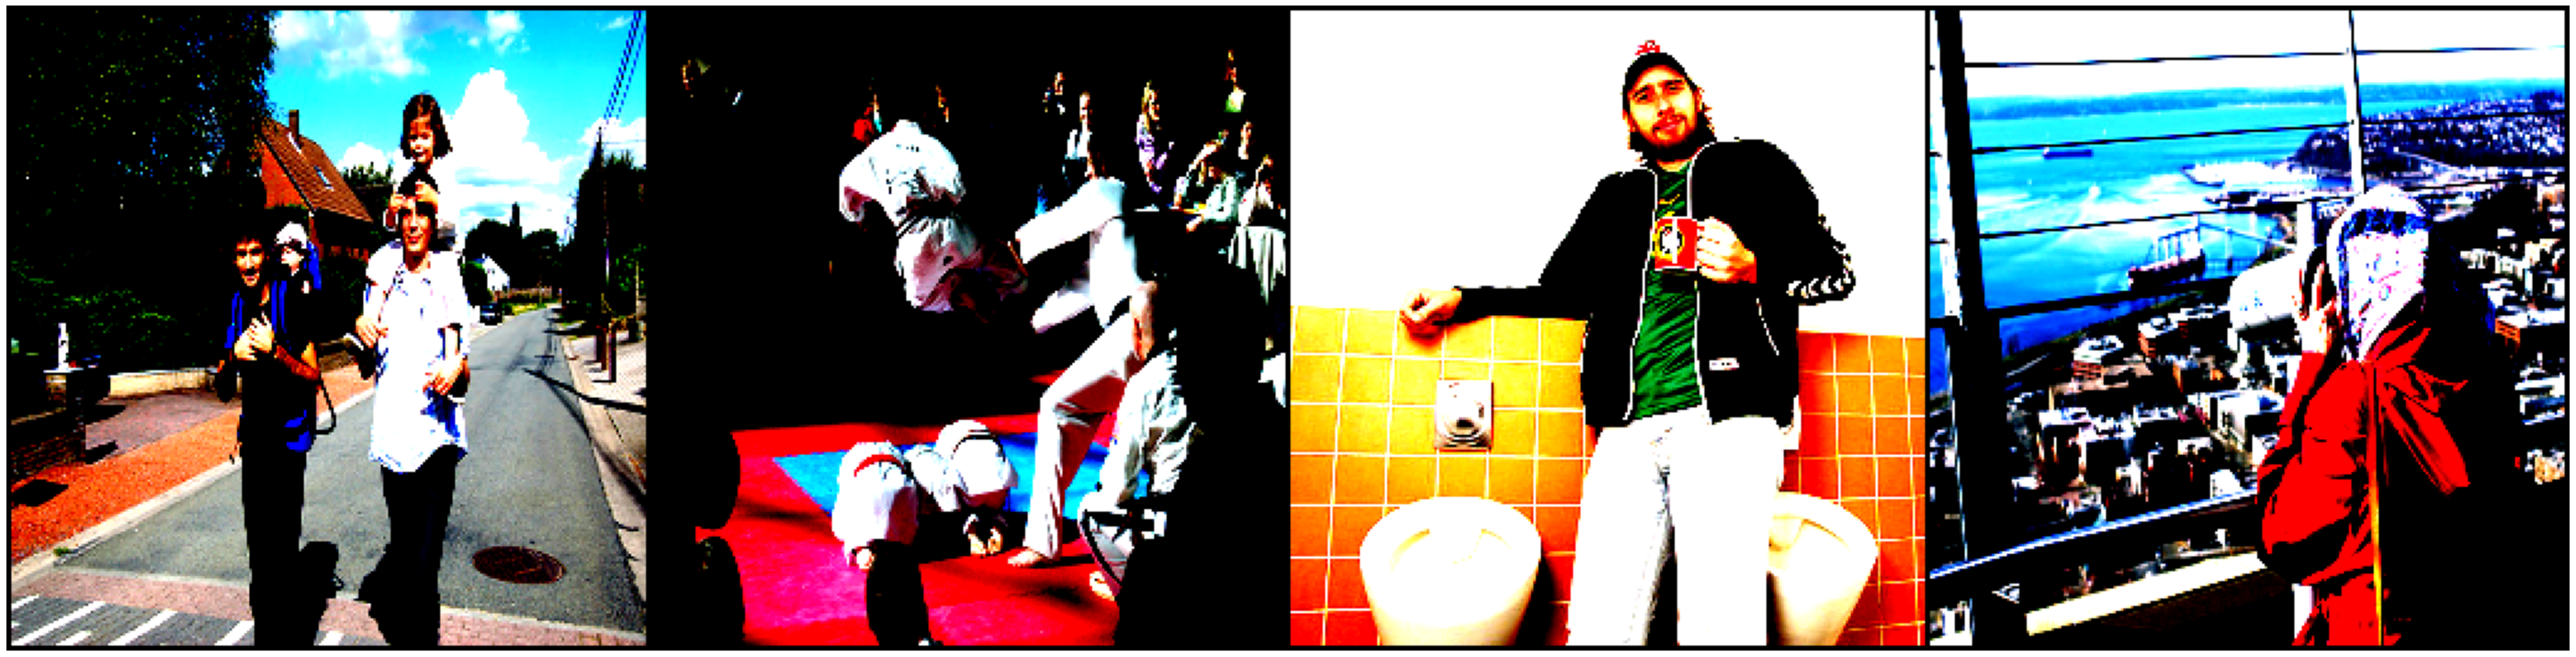

In [22]:
dataloader = DataLoader(caption_dataset, batch_size=4, shuffle=True, num_workers=0, collate_fn=collate_fn)

# Helper function to show a batch 
def plot_batch(sample_batched):
    """Show image for a batch of samples."""
    images_batch, captions_batch, lengths = sample_batched[0], sample_batched[1], sample_batched[2]
    print(images_batch.shape, captions_batch.shape, lengths)
    captions = [] 
    for caption_tensor in captions_batch:
        idx_to_word_tensor = list(map(lambda x: convert_idx_to_word(x, dic), caption_tensor))
        captions.append(idx_to_word_tensor)
    print(captions)
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2
    
    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose(1, 2, 0))
    
for i_batch, sample_batched in enumerate(dataloader):    
    # observe 0th batch and stop.
    if i_batch == 0:
        plt.figure(figsize=(50, 50)) 
        plot_batch(sample_batched)
        plt.axis('off')
        plt.ioff() 
        plt.show()
        break 